## Firsts tests with h5py and FLAMINGO data

In [ ]:
import h5py
import swiftsimio as sw
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from tqdm import tqdm
import os 

path_hydro = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_hydro, "r") as handle:
    M200m = handle["SO/200_mean/TotalMass"][:]*1e10 #mass is stored in units of 1e10 solar masses
    R200m = handle["SO/200_mean/SORadius"][:] #radii, centres and positions are in Mpc
    centre = handle["InputHalos/HaloCentre"][...]


Largest 200m mass: 3.835e+15 Msol
Or 15.583751678466797 in logspace


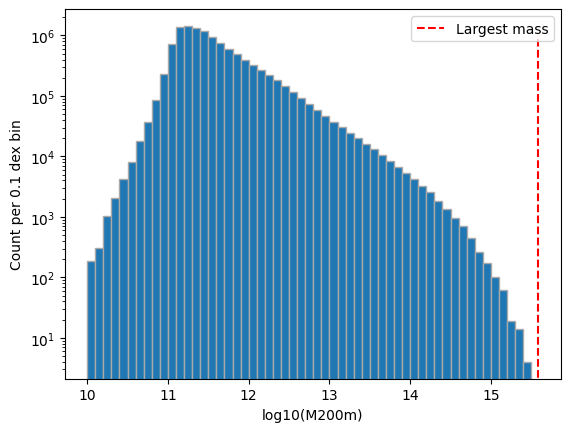

In [2]:
print(f'Largest 200m mass: {np.max(M200m):.3e} Msol')

logM200m = np.log10(M200m[M200m >= 1e10])
max_dex = np.max(logM200m)
print(f'Or {max_dex} in logspace')

fig,ax = plt.subplots()
ax.hist(logM200m,bins=np.arange(10,max_dex,0.1),log=True,edgecolor='darkgrey')
# ax.tick_params(which='both')
ax.set(xlabel = 'log10(M200m)', ylabel = 'Count per 0.1 dex bin')
ax.vlines(np.max(logM200m),0,1e6,label='Largest mass', linestyles='--', colors='red')
ax.legend()
plt.show()

In [3]:
##Example 2

path_hydro = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_hydro, "r") as handle:
    Mstar = handle["SO/200_mean/StellarMass"][:]*1e10 #mass is stored in units of 1e10 solar masses
    Mgas = handle["SO/200_mean/GasMass"][:]*1e10 #mass is stored in units of 1e10 solar masses

#where arg to ignore 0's
logMstar = np.log10(Mstar,where=Mstar!=0)
logMgas = np.log10(Mgas,where=Mgas!=0)
logM200m = np.log10(M200m,where=M200m!=0)

nonzero = (logMgas >= 10) * (logMstar >= 10 ) 
bar_frac = (Mgas[nonzero] + Mstar[nonzero]) / (M200m[nonzero])


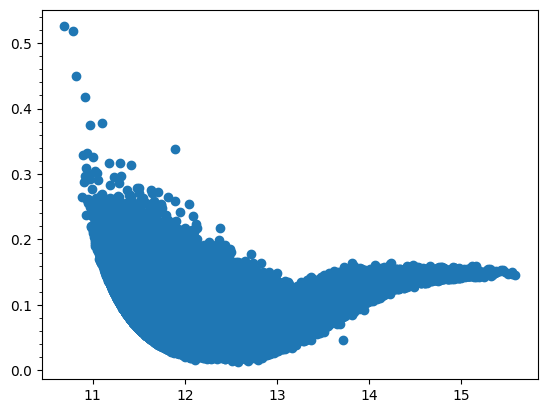

In [4]:
import matplotlib.ticker as ticker
fig,ax = plt.subplots()
ax.scatter(logM200m[nonzero], bar_frac)
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.show()

In [20]:
#Example 3


path_hydro = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_hydro, "r") as handle:
    centre = handle["InputHalos/HaloCentre"][...]
    Stellarmass = handle['ExclusiveSphere/50kpc/StellarMass'][:] * 1e10


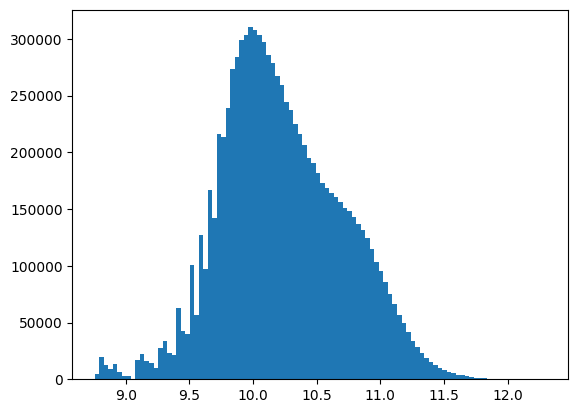

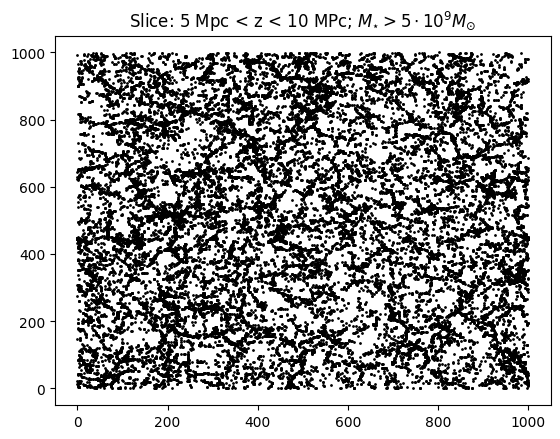

In [44]:
logStellarMass = np.log10(Stellarmass[Stellarmass != 0])

plt.figure()
plt.hist(logStellarMass,bins=100)
plt.show()

centre_x, centre_y, centre_z = centre[Stellarmass > 5*1e9].T
zmask = (5 < centre_z) * (centre_z < 10)
plt.figure()
plt.scatter(centre_x[zmask], centre_y[zmask], s = 1, c='black')
plt.title(r'Slice: 5 Mpc < z < 10 MPc; $M_{\star} > 5\cdot10^9 M_{\odot}$')
plt.show()

In [3]:
## Example 4
import os 

path_DMO = "/net/hypernova/data2/FLAMINGO/L1000N1800/DMO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_DMO, "r") as handle:
    # M200m = handle["SO/200_mean/TotalMass"][:]*1e10 #mass is stored in units of 1e10 solar masses
    R200m = handle["SO/200_mean/SORadius"][:][0] #radii, centres and positions are in Mpc
    R500c = handle["SO/500_crit/SORadius"][:][0]
    centre = handle["InputHalos/HaloCentre"][...][0]
    HaloCatalogueIndex=handle["InputHalos/HaloCatalogueIndex"][:][0] # To match to particles

print(HaloCatalogueIndex)

snapshot_path = "/net/hypernova/data2/FLAMINGO/L1000N1800/DMO_FIDUCIAL/snapshots/flamingo_0077"
membership_path = "/net/hypernova/data2/FLAMINGO/L1000N1800/DMO_FIDUCIAL/SOAP-HBT/membership_0077"



12283760


In [25]:
hasattr([],'__iter__')

True

In [ ]:
from tqdm import tqdm 

def extract_galaxy_particles(snapshot_path,membership_path,PartType = 1, HaloCatalogueIndex = HaloCatalogueIndex):
    if isinstance(PartType,int):
        Particle_Coords = np.array([])

        for i in tqdm(range(len(os.listdir(membership_path)))):
            snapshot_path_i = os.path.join(snapshot_path,f"flamingo_0077.{i}.hdf5")
            membership_path_i = os.path.join(membership_path,f"membership_0077.{i}.hdf5")

            with h5py.File(membership_path_i,'r') as membership_handle:
                GroupNr_bound = membership_handle[f'/PartType{PartType}/GroupNr_bound'][:]
            
            #Select desired Halo(es)
            HaloMask = GroupNr_bound == HaloCatalogueIndex

            with h5py.File(snapshot_path_i, 'r') as snapshot_handle:
                #: i want x,y,z
                Coords = snapshot_handle[f'PartType{PartType}/Coordinates'][:,HaloMask] # only correct if masked, otherwise ...
            Particle_Coords = np.append(Particle_Coords, Coords) #bad!

        Particle_Coords = Particle_Coords.reshape(-1,3) #To reshape to 3-arrays inside the array
        return Particle_Coords

    #Multiple PartTypes at the same time
    elif hasattr(PartType,'__iter__'):        
        Particle_Coords = {i:np.array([]) for i in PartType}
        HaloMasks = {}

        for i in tqdm(range(len(os.listdir(membership_path)))):
            snapshot_path_i = os.path.join(snapshot_path,f"flamingo_0077.{i}.hdf5")
            membership_path_i = os.path.join(membership_path,f"membership_0077.{i}.hdf5")

            with h5py.File(membership_path_i,'r') as membership_handle:
                for PType in PartType:
                    GroupNr_bound = membership_handle[f'/PartType{PType}/GroupNr_bound'][:]
                    #Select desired Halo(es)
                    HaloMask = GroupNr_bound == HaloCatalogueIndex
                    HaloMasks[PType] = HaloMask

            with h5py.File(snapshot_path_i, 'r') as snapshot_handle:
                for PType in PartType:
                    Coords = snapshot_handle[f'PartType{PType}/Coordinates'][:][HaloMasks[PType]] #Immediately mask only to wanted haloes
                    Particle_Coords[PType] = np.append(Particle_Coords[PType], Coords)
            
            HaloMasks = {}

        return [pcoords.reshape(-1,3) for pcoords in Particle_Coords.values()] #Reshape the indivual particle types coordinates to desired format


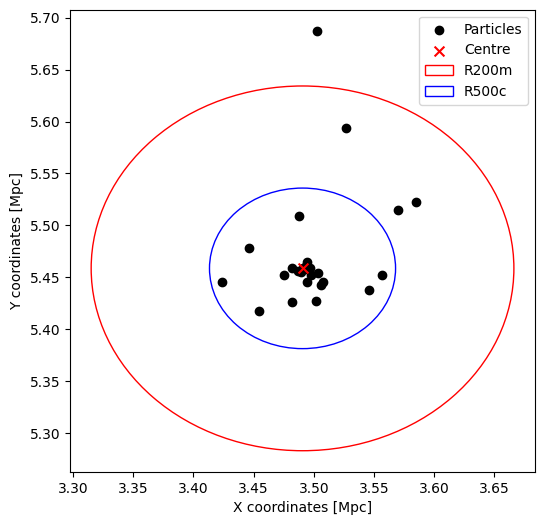

In [ ]:
Particle_Coords = extract_galaxy_particles(snapshot_path, membership_path)
x,y,z = Particle_Coords.T
centre_x,centre_y,centre_z = centre

from matplotlib import patches

fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(x,y,c='black',label='Particles')
ax.scatter(centre_x,centre_y,marker='x',c='red',s=50,zorder=10,label='Centre')

Circle_200m = patches.Circle(xy = (centre_x,centre_y),radius = R200m, color='red',fill=False,label='R200m')
Circle_500c = patches.Circle(xy = (centre_x,centre_y),radius = R500c, color='blue',fill=False,label='R500c')
ax.add_patch(Circle_200m)
ax.add_patch(Circle_500c)

ax.set(xlabel='X coordinates [Mpc]',ylabel = 'Y coordinates [Mpc]')
plt.legend()
plt.show()

In [ ]:
## Example 5

path_HYDRO = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"
with h5py.File(path_HYDRO, "r") as handle:
    R200m = handle["SO/200_mean/SORadius"][:][0] #radii, centres and positions are in Mpc
    R500c = handle["SO/500_crit/SORadius"][:][0]
    centre = handle["InputHalos/HaloCentre"][...][0]
    HaloCatalogueIndex = handle["InputHalos/HaloCatalogueIndex"][:][0] # To match to particles

snapshot_path_HYDRO = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/snapshots/flamingo_0077"
membership_path_HYDRO = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/membership_0077"


In [41]:
# With this method I open the files only once and extract all the necessary parts at once: ~ twice as fast!
DMCoords, StarCoords = extract_galaxy_particles(snapshot_path_HYDRO, membership_path_HYDRO, PartType=(1,4), HaloCatalogueIndex = HaloCatalogueIndex)

100%|██████████| 64/64 [18:19<00:00, 17.17s/it]


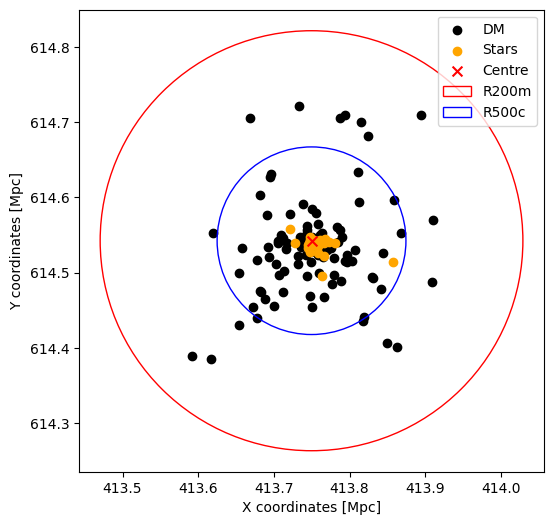

In [42]:
from matplotlib import patches

# Extract the indivual coordinates, easily done in 1 line due to how the particle coords were saved
DMx,DMy,_ = DMCoords.T
Starx,Stary,_ = StarCoords.T
centre_x,centre_y,_ = centre

fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(DMx,DMy,c='black',label='DM')
ax.scatter(Starx,Stary,c='orange',label='Stars')
ax.scatter(centre_x,centre_y,marker='x',c='red',s=50,zorder=10,label='Centre')

Circle_200m = patches.Circle(xy = (centre_x,centre_y),radius = R200m, color='red',fill=False,label='R200m')
Circle_500c = patches.Circle(xy = (centre_x,centre_y),radius = R500c, color='blue',fill=False,label='R500c')
ax.add_patch(Circle_200m)
ax.add_patch(Circle_500c)

ax.set(xlabel='X coordinates [Mpc]',ylabel = 'Y coordinates [Mpc]')
plt.legend()
plt.show()